In [20]:
import pandas as pd
import csv
from collections import defaultdict as dd
import re
from matplotlib.pyplot import scatter  
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from scipy.stats import ttest_1samp

In [62]:
new_data_fn = 'collected_epa_ratings.csv' 
predicted_data_fns = 'predictions.csv'
rejected_workers = {'A351P2O6QGTCS',
                    'A4J4GGMKJ68L0',
                    'A351P2O6QGTCS',
                    'A29VL3MZE7YPBZ',
                    'A2T1K94BLNDBAH',
                    'ARJ6SPCZJVARE',
                    'AV5DCU1VH5S34'}
dropped_workers = {'A1B5SSGMTAQ9B5',
                   'A1LOD3LNX7FUPJ',
                   'A1QTQISKEHWSKZ',
                   'A24ZKEJTS1O4IW',
                   'A266LNUJOVKCDS',
                   'A29VL3MZE7YPBZ',
                   'A2ET3KM3IE33MM',
                   'A2QH1BQA6GR48O',
                   'A351P2O6QGTCS',
                   'A38DAH5RS19EX4',
                   'A3GNQDFPZALU92',
                   'A3RYI5HXC2MJLN',
                   'A4J4GGMKJ68L0',
                   'AJDXSXAWDDAEO'}

In [130]:
def get_word(phrase):
    beh_regex = ['^to\s([^\s]*)\s?(?:with|to|at|towards|on|upon|something to)?\ssomeone\sis$']
    id_regex = ['an? (.*?) is']
    mod_regex = ['^being\s([^\s]*)\sis$','^feeling\s([^\s]*)\sis$']
    beh = 0
    mod = 0
    id_ = 0
        
    for r in beh_regex:
        match = re.search(r, str(phrase))
        if match:
            term = match.group(1)
            beh = 1
               
    if not beh:
        for r in id_regex:
            match = re.search(r, str(phrase))
            if match:
                term = match.group(1)
                id_ = 1
       
    if not beh and not id_:
        for r in mod_regex:
            match = re.search(r, str(phrase))
            if match:
                term = match.group(1)
                mod = 1
                
    if not beh and not id_ and not mod:
        print(phrase)
        return None
                
    return term,(beh, id_, mod)

In [64]:
e_ratings = dd(list)
p_ratings = dd(list)
a_ratings = dd(list)
all_words_collected = set()

with open(new_data_fn) as fn:
    reader = csv.DictReader(fn)
    for row in reader:
        if row['rating_value'] == 'SKIP':
            continue
        if row['mturk_id'] in rejected_workers.union(dropped_workers):
            continue
        score = float(row['rating_value'])
        term, pos = get_word(row['phrase'])
        all_words_collected.add(term)
        if row['dimension'] == 'evaluative':
            e_ratings[term].append(score)
        elif row['dimension'] == 'potency':
            p_ratings[term].append(score)
        elif row['dimension'] == 'activity':
            a_ratings[term].append(score)
        else:
            print(row['dimension'])
            
epa_ratings_collected = {w: {'e': sum(e_ratings[w])/len(e_ratings[w]),
                             'p': sum(p_ratings[w])/len(p_ratings[w]),
                             'a': sum(a_ratings[w])/len(a_ratings[w])} for w in all_words_collected}

In [65]:
epa_ratings_predicted = {}
all_words_predicted = set()

with open(predicted_data_fns) as fn:
    reader = csv.DictReader(fn)
    for row in reader:
        term = row['Term']
        all_words_predicted.add(term)
        epa_ratings_predicted[term] = {'e': float(row['E']),
                                       'p': float(row['P']),
                                       'a': float(row['A'])}

In [158]:
epa_ratings_old = {'term': [],
                   'e_new': [],
                   'p_new': [],
                   'a_new': []}
old_words = set()

with open('EPA_dict.csv', 'r') as f:
    
    f.readline() #Pass over the first line of the file
    
    for line in f:

        line = line.lower().split(',')
        if get_word(str(line[0])):
            epa_ratings_old['term'].append(get_word(str(line[0]))[0])
            epa_ratings_old['e_new'].append(float(line[2]))
            epa_ratings_old['p_new'].append(float(line[3]))
            epa_ratings_old['a_new'].append(float(line[4]))
        
        if get_word(str(line[0])):
            old_words.add(get_word(str(line[0]))[0])

epa_ratings_new = {'term':[w for w in epa_ratings_collected.keys() if w in old_words],
                   'e_old': [epa_ratings_collected[w]['a'] for w in epa_ratings_collected.keys() if w in old_words],
                   'p_old': [epa_ratings_collected[w]['a'] for w in epa_ratings_collected.keys() if w in old_words],
                   'a_old': [epa_ratings_collected[w]['a'] for w in epa_ratings_collected.keys() if w in old_words]}        

retested_terms_new = pd.DataFrame.from_dict(epa_ratings_new)
retested_terms_old = pd.DataFrame.from_dict(epa_ratings_old)
df = retested_terms_new.merge(retested_terms_old, how='left', on='term')

a machine repairer
a machine repairer
a polymath   1
a polymath   1
being able bodied is
being able bodied is
being abusive physically is
being abusive physically is
being abusive verbally is
being abusive verbally is
being bad tempered is
being bad tempered is
being broad minded is
being broad minded is
being fun loving is
being fun loving is
being good natured is
being good natured is
being light hearted is
being light hearted is
being lower class is
being lower class is
being mentally ill is
being mentally ill is
being mentally retarded is
being mentally retarded is
being middle aged is
being middle aged is
being middle class is
being middle class is
being neighborly
being neighborly
being obsessive compulsive is
being obsessive compulsive is
being old fashioned is
being old fashioned is
being open minded is
being open minded is
being self assured is
being self assured is
being self centered is
being self centered is
being self confident is
being self confident is
being self discipl

In [182]:
from scipy.stats import ttest_rel as tt
print('E:',tt(df['e_old'],df['e_new']))
print('P:',tt(df['p_old'],df['p_new']))
print('A:',tt(df['a_old'],df['a_new']))

E: Ttest_relResult(statistic=2.0863325501557344, pvalue=0.038575673151129496)
P: Ttest_relResult(statistic=-1.3580836535435803, pvalue=0.1763980764546495)
A: Ttest_relResult(statistic=-5.444889494356119, pvalue=1.975585008535982e-07)


In [187]:
print(np.mean(df['e_new']) - np.mean(df['e_old']))
print(np.mean(df['p_new']) - np.mean(df['p_old']))
print(np.mean(df['a_new']) - np.mean(df['a_old']))

-0.4727819167043796
0.17749676509179857
0.2460368311300153


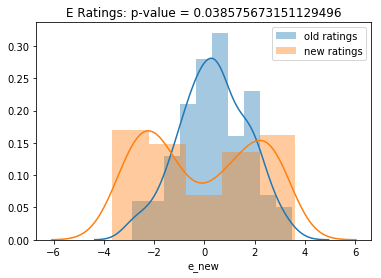

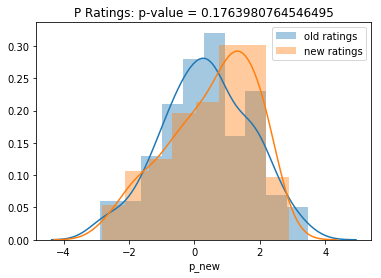

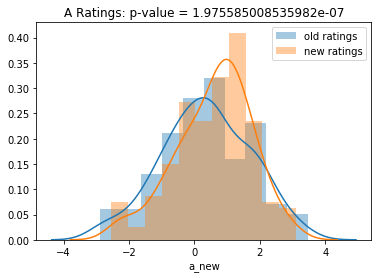

In [183]:
import seaborn as sb

sb.distplot(df['e_old'], label='old ratings')
sb.distplot(df['e_new'], label='new ratings')
plt.legend()
plt.title('E Ratings: p-value = {}'.format((tt(df['e_old'],df['e_new'])[1])))
plt.show()

sb.distplot(df['p_old'], label='old ratings')
sb.distplot(df['p_new'], label='new ratings')
plt.legend()
plt.title('P Ratings: p-value = {}'.format((tt(df['p_old'],df['p_new'])[1])))
plt.show()

sb.distplot(df['a_old'], label='old ratings')
sb.distplot(df['a_new'], label='new ratings')
plt.legend()
plt.title('A Ratings: p-value = {}'.format((tt(df['a_old'],df['a_new'])[1])))
plt.show()

In [128]:
count = 0

with open('EPA_dict.csv', 'r') as f:
    
    f.readline() #Pass over the first line of the file
    
    for line in f:
        
        if count < 10:

            line = line.lower().split(',')
        
            print(epa_ratings_old['term'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
words = all_words_predicted.intersection(all_words_collected)

E_pred = []
P_pred = []
A_pred = []

E_act = []
P_act = []
A_act = []

for w in words:
    E_pred.append(epa_ratings_collected[w]['e'])
    P_pred.append(epa_ratings_collected[w]['p'])
    A_pred.append(epa_ratings_collected[w]['a'])
    E_act.append(epa_ratings_predicted[w]['e'])
    P_act.append(epa_ratings_predicted[w]['p'])
    A_act.append(epa_ratings_predicted[w]['a'])

In [68]:
e_E = [E_pred[i] - E_act[i] for i in range(len(E_pred))]
e_P = [P_pred[i] - P_act[i] for i in range(len(P_pred))]
e_A = [A_pred[i] - A_act[i] for i in range(len(A_pred))]

ae_E = [abs(x) for x in e_E]
ae_P = [abs(x) for x in e_P]
ae_A = [abs(x) for x in e_A]

In [69]:
print(ttest_1samp(e_E, 0))
print(ttest_1samp(e_P, 0))
print(ttest_1samp(e_A, 0))

Ttest_1sampResult(statistic=-0.7159599429364208, pvalue=0.47466863579867924)
Ttest_1sampResult(statistic=0.26876678786956104, pvalue=0.7883256214035241)
Ttest_1sampResult(statistic=0.7805698388413685, pvalue=0.43577669395837215)


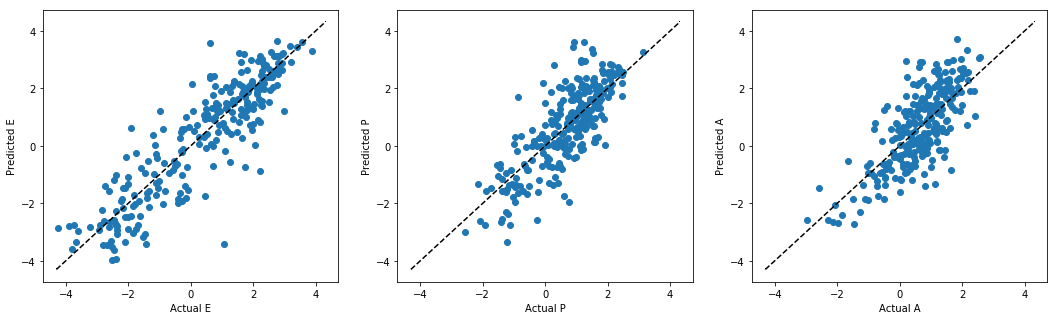

In [104]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt1.scatter(E_act, E_pred)
plt1.plot([-4.3, 4.3], [-4.3, 4.3], 'k,--')
plt.xlabel('Actual E')
plt.ylabel('Predicted E')

plt2 = plt.subplot(1, 3, 2)
plt2.scatter(P_act, P_pred)
plt2.plot([-4.3, 4.3], [-4.3, 4.3], 'k,--')
plt.xlabel('Actual P')
plt.ylabel('Predicted P')

plt3 = plt.subplot(1, 3, 3)
plt3.scatter(A_act, A_pred)
plt3.plot([-4.3, 4.3], [-4.3, 4.3], 'k,--')
plt.xlabel('Actual A')
plt.ylabel('Predicted A')

plt.show()

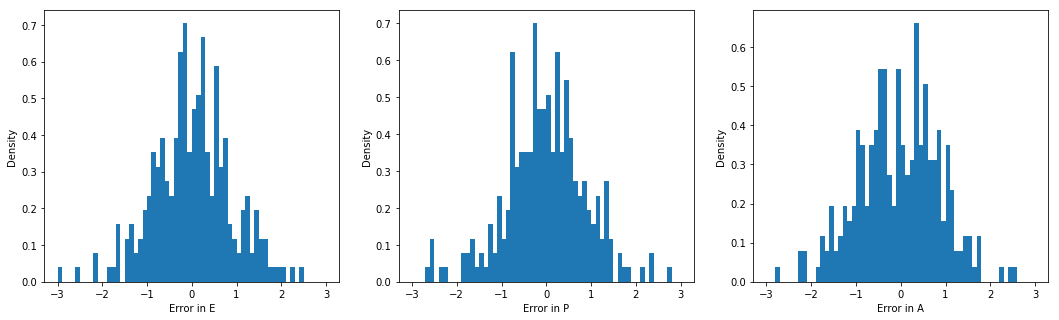

In [110]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt.hist([E_act[i] - E_pred[i] for i in range(len(E_pred))], bins=60, density=True, range=(-3,3))
plt.xlabel('Error in E')
plt.ylabel('Density')

plt2 = plt.subplot(1, 3, 2)
plt.hist([P_act[i] - P_pred[i] for i in range(len(P_pred))], bins=60, density=True, range=(-3,3))
plt.xlabel('Error in P')
plt.ylabel('Density')

plt3 = plt.subplot(1, 3, 3)
plt.hist([A_act[i] - A_pred[i] for i in range(len(A_pred))], bins=60, density=True, range=(-3,3))
plt.xlabel('Error in A')
plt.ylabel('Density')

plt.show()

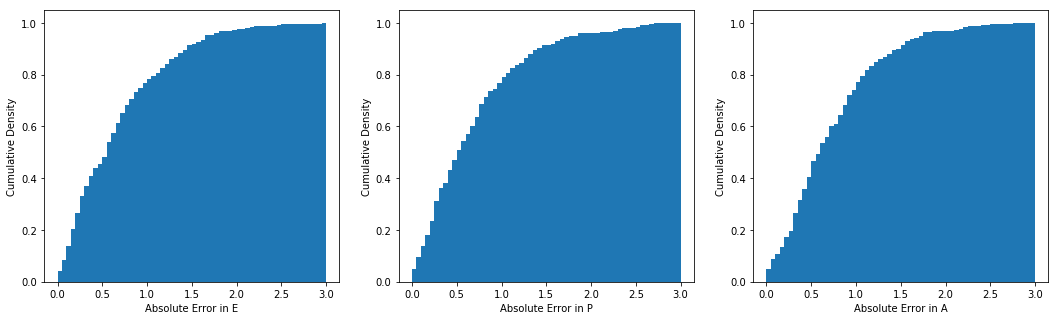

In [111]:
fig = plt.figure(figsize=(18, 5)) 

plt1 = plt.subplot(1, 3, 1)
plt.hist(ae_E,bins=60,density=True, cumulative=True, range=(0,3))
plt.xlabel('Absolute Error in E')
plt.ylabel('Cumulative Density')

plt2 = plt.subplot(1, 3, 2)
plt.hist(ae_P,bins=60,density=True, cumulative=True, range=(0,3))
plt.xlabel('Absolute Error in P')
plt.ylabel('Cumulative Density')

plt3 = plt.subplot(1, 3, 3)
plt.hist(ae_A,bins=60,density=True, cumulative=True, range=(0,3))
plt.xlabel('Absolute Error in A')
plt.ylabel('Cumulative Density')

plt.show()

In [73]:
round(r2(E_pred, E_act), 3)

0.789

In [74]:
round(r2(P_pred, P_act), 3)

0.621

In [75]:
round(r2(A_pred, A_act), 3)

0.552

In [76]:
round(mae(E_pred, E_act), 3)

0.696

In [77]:
round(mae(P_pred, P_act), 3)

0.683

In [78]:
round(mae(A_pred, A_act), 3)

0.727

In [89]:
new = {k: 0 for k in rejected_workers.union(dropped_workers)}

n = 0
with open(new_data_fn) as fn:
    reader = csv.DictReader(fn)
    for row in reader:
        if row['rating_value'] == 'SKIP':
            continue
        if row['mturk_id'] in rejected_workers.union(dropped_workers):
            new[row['mturk_id']] += 1
        
#print(n)
#print(rejected_workers.union(dropped_workers) - new)
new

{'A1B5SSGMTAQ9B5': 90,
 'A1LOD3LNX7FUPJ': 90,
 'A1QTQISKEHWSKZ': 90,
 'A24ZKEJTS1O4IW': 180,
 'A266LNUJOVKCDS': 87,
 'A29VL3MZE7YPBZ': 90,
 'A2ET3KM3IE33MM': 90,
 'A2QH1BQA6GR48O': 89,
 'A2T1K94BLNDBAH': 180,
 'A351P2O6QGTCS': 90,
 'A38DAH5RS19EX4': 90,
 'A3GNQDFPZALU92': 89,
 'A3RYI5HXC2MJLN': 90,
 'A4J4GGMKJ68L0': 88,
 'AJDXSXAWDDAEO': 90,
 'ARJ6SPCZJVARE': 90,
 'AV5DCU1VH5S34': 90}

In [98]:
np.mean(P_pred)

0.6579003651342377

In [99]:
np.std(P_pred)

1.4461073027229383

In [100]:
np.mean(P_act)

0.6429436342412452

In [101]:
np.std(P_act)

1.0733482954395606